In [1]:
import numpy as np
import pandas as pd
import jsonlines
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

***
## train-m1

In [2]:
!ls ../data

items_static_metadata_full.jl train_data.parquet
metadata.csv                  unpredictable.csv
sample_submission.csv.gz      validation_realstock.csv
scales.csv                    validation_seed17.csv
skus_assess_m1.yaml           validation_seed17_harder.csv
skus_assess_m2.yaml           validation_seed19.csv
test-m1.parquet               validation_seed19_harder.csv
test-m2.parquet               validation_seed2.csv
test_data.csv                 validation_seed23.csv
train-m1.parquet              validation_seed23_harder.csv
train-m2.parquet              validation_seed2_harder.csv


In [3]:
data = pd.read_parquet("../data/train_data.parquet")
data

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.000000
...,...,...,...,...,...,...,...,...,...
37660274,129187,2021-03-31,0,22057.00,ARG,classic,drop_off,free_shipping,267.710767
37660275,6707,2021-03-31,0,26999.00,ARG,classic,cross_docking,free_shipping,266.083333
37660276,170355,2021-03-31,0,3400.00,ARG,classic,drop_off,paid_shipping,0.252633
37660277,246568,2021-03-31,0,6289.00,ARG,classic,fulfillment,free_shipping,135.416667


In [4]:
data.sku.nunique()/1e3

660.916

In [5]:
data.drop_duplicates(subset=["sku"]).currency.value_counts() / 1e3

REA    336.334
MEX    265.908
ARG     58.670
DOL      0.004
Name: currency, dtype: float64

In [6]:
data.drop_duplicates(subset=["sku"]).listing_type.value_counts() / 1e3

premium    332.767
classic    328.149
Name: listing_type, dtype: float64

In [7]:
data.drop_duplicates(subset=["sku"]).shipping_logistic_type.value_counts() / 1e3

fulfillment      489.501
drop_off         104.131
cross_docking     67.284
Name: shipping_logistic_type, dtype: float64

In [8]:
data.drop_duplicates(subset=["sku"]).shipping_payment.value_counts() / 1e3

paid_shipping    438.793
free_shipping    222.123
Name: shipping_payment, dtype: float64

In [9]:
data.groupby("date")["sku"].count()

date
2021-02-01    604230
2021-02-02    606383
2021-02-03    608270
2021-02-04    610721
2021-02-05    612461
2021-02-06    613405
2021-02-07    613950
2021-02-08    615477
2021-02-09    616976
2021-02-10    618612
2021-02-11    620325
2021-02-12    621937
2021-02-13    622608
2021-02-14    622964
2021-02-15    624165
2021-02-16    625438
2021-02-17    626922
2021-02-18    628333
2021-02-19    629555
2021-02-20    630067
2021-02-21    630470
2021-02-22    631777
2021-02-23    633111
2021-02-24    634601
2021-02-25    636062
2021-02-26    637263
2021-02-27    637768
2021-02-28    638166
2021-03-01    639351
2021-03-02    640562
2021-03-03    641856
2021-03-04    643137
2021-03-05    644620
2021-03-06    645072
2021-03-07    645432
2021-03-08    646451
2021-03-09    647382
2021-03-10    648410
2021-03-11    649447
2021-03-12    650309
2021-03-13    650732
2021-03-14    651006
2021-03-15    651728
2021-03-16    652524
2021-03-17    653317
2021-03-18    654154
2021-03-19    654845
2021-03-

In [10]:
# number of rows by sku
len(data)/data.sku.nunique()

56.9819447554606

In [11]:
data.groupby("sku")["date"].count().describe()

count    660916.000000
mean         56.981945
std           8.094631
min           1.000000
25%          59.000000
50%          59.000000
75%          59.000000
max          59.000000
Name: date, dtype: float64

In [12]:
data.groupby("sku")["sold_quantity"].mean().describe()

count    660916.000000
mean          0.983020
std           6.988492
min           0.000000
25%           0.203390
50%           0.338983
75%           0.711864
max        2330.983051
Name: sold_quantity, dtype: float64

In [13]:
data.groupby("sku")["date"].count().describe()

count    660916.000000
mean         56.981945
std           8.094631
min           1.000000
25%          59.000000
50%          59.000000
75%          59.000000
max          59.000000
Name: date, dtype: float64

In [14]:
# % of null by column
data.isna().sum(axis=0)/len(data)

sku                       0.0
date                      0.0
sold_quantity             0.0
current_price             0.0
currency                  0.0
listing_type              0.0
shipping_logistic_type    0.0
shipping_payment          0.0
minutes_active            0.0
dtype: float64

***
## analysis of minutes active

In [15]:
print("Million rows with inactive status:", len(data.query("minutes_active == 0")) / 1e6)
print("% rows with inactive status:", 100 * len(data.query("minutes_active == 0")) / len(data))

Million rows with inactive status: 9.564117
% rows with inactive status: 25.395767779627974


<AxesSubplot:>

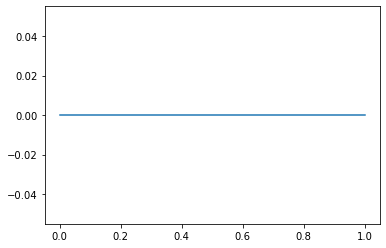

In [16]:
data.query("minutes_active == 0").sold_quantity.quantile(np.arange(0.001,1,0.001)).plot()

In [17]:
# outliers
display(data.query("minutes_active == 0").query("sold_quantity > 0"))
display(data.query("minutes_active == 0").query("sold_quantity > 0").sold_quantity.describe())

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
90110,556825,2021-03-18,1,9.29,REA,premium,fulfillment,paid_shipping,0.0
235261,618910,2021-03-17,4,96.90,REA,premium,fulfillment,free_shipping,0.0
239432,40775,2021-03-17,1,69.89,REA,classic,fulfillment,paid_shipping,0.0
2205981,566403,2021-03-17,2,147.11,REA,premium,fulfillment,free_shipping,0.0
2345110,653657,2021-03-17,1,29.90,REA,premium,fulfillment,paid_shipping,0.0
...,...,...,...,...,...,...,...,...,...
37601635,119359,2021-03-17,4,14999.00,ARG,classic,fulfillment,free_shipping,0.0
37609049,216635,2021-03-17,5,1290.00,ARG,classic,fulfillment,paid_shipping,0.0
37620800,162807,2021-03-11,2,145.00,ARG,classic,cross_docking,paid_shipping,0.0
37624412,359176,2021-03-23,2,57.00,ARG,classic,fulfillment,paid_shipping,0.0


count    611.000000
mean       3.765957
std       10.077530
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      153.000000
Name: sold_quantity, dtype: float64

In [18]:
data["inactive"] = False
idx = data.query("minutes_active <= 120").index
data.loc[idx,"inactive"] = True

In [19]:
df = (data.groupby("sku")["inactive"].sum() / data.groupby("sku")["date"].count()).reset_index(name="inactive_perc")
df

,sku,inactive_perc
0,0,0.118644
1,1,0.525424
2,2,0.000000
3,3,0.559322
4,4,0.576271
...,...,...
660911,660911,0.135593
660912,660912,0.101695
660913,660913,0.118644
660914,660914,0.067797


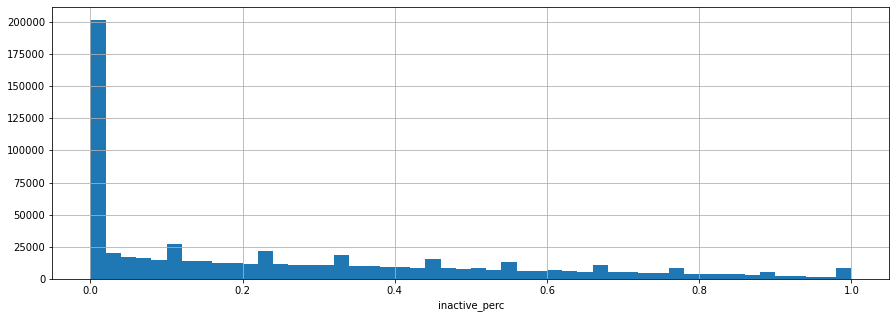

In [20]:
plt.figure(figsize=(15,5))
plt.hist(df.inactive_perc, bins=50)
plt.grid()
plt.xlabel("inactive_perc")
plt.show()

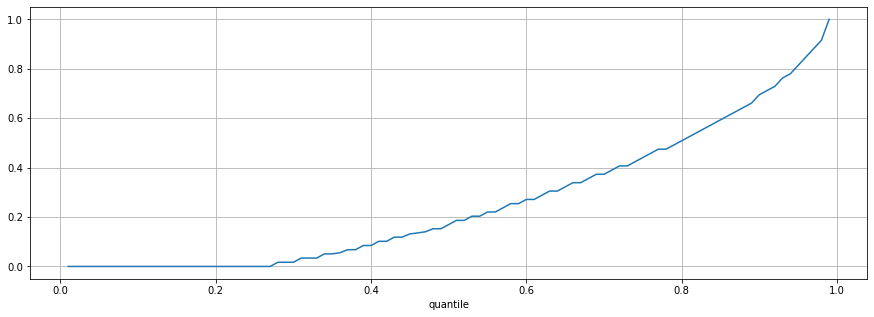

count    660916.000000
mean          0.258715
std           0.273571
min           0.000000
25%           0.000000
50%           0.169492
75%           0.440678
max           1.000000
Name: inactive_perc, dtype: float64

In [21]:
qvalues = np.arange(0.01,1,0.01)
quantiles = df.inactive_perc.quantile(qvalues)

plt.figure(figsize=(15,5))
plt.plot(qvalues, quantiles)
plt.grid()
plt.xlabel("quantile")
plt.show()

df.inactive_perc.describe()

In [22]:
# perc of skus inactive on last training date
print("Number of skus:", data.query("date == '2021-03-31'").inactive.sum())
print("Perc of skus:", 100 * data.query("date == '2021-03-31'").inactive.sum() / len(data.query("date == '2021-03-31'")))

Number of skus: 184010
Perc of skus: 27.841662177946972


In [23]:
# perc of skus inactive on last week of training data
print("Number of skus:", (data.query("'2021-03-25' <= date <= '2021-03-31'").groupby("sku")["inactive"].sum() == 7).sum())
print("Perc of skus:", 100 * (data.query("'2021-03-25' <= date <= '2021-03-31'").groupby("sku")["inactive"].sum() == 7).sum() / data.query("'2021-03-25' <= date <= '2021-03-31'").sku.nunique())

Number of skus: 128580
Perc of skus: 19.454817253629813


***
## test data

In [24]:
test = pd.read_csv("../data/test_data.csv")
test.sku.nunique()

551472

In [25]:
test.sku.nunique() / data.sku.nunique()

0.8344055825551204

In [26]:
set(test.sku) < set(data.sku)

True

In [27]:
test.target_stock.describe()

count    551472.000000
mean         18.069472
std         122.711151
min           1.000000
25%           3.000000
50%           6.000000
75%          13.000000
max       32710.000000
Name: target_stock, dtype: float64

In [28]:
data.query("sku in @test.sku").groupby(["sku"])["date"].count().describe()

count    551472.000000
mean         56.728949
std           8.642053
min           1.000000
25%          59.000000
50%          59.000000
75%          59.000000
max          59.000000
Name: date, dtype: float64

In [29]:
data.query("sku in @test.sku").groupby(["sku"])["sold_quantity"].sum().describe()

count    551472.000000
mean         57.920747
std         442.711305
min           0.000000
25%          10.000000
50%          19.000000
75%          40.000000
max      137528.000000
Name: sold_quantity, dtype: float64

In [30]:
(data.groupby("sku")["sold_quantity"].sum() == 0)[test.sku.values].sum()

25283

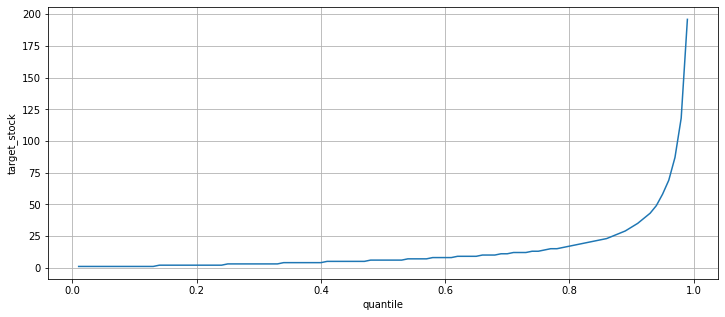

In [31]:
quantiles = np.arange(0.01, 1, 0.01)
values = test.target_stock.quantile(quantiles)

plt.figure(figsize=(12,5))
plt.plot(quantiles, values)
plt.grid()
plt.xlabel("quantile")
plt.ylabel("target_stock")
plt.show()

In [32]:
_data = data.query("sku in @test.sku.values").copy()

_data["inactive"] = False
idx = _data.query("minutes_active <= 120").index
_data.loc[idx,"inactive"] = True

In [33]:
df = (_data.groupby("sku")["inactive"].sum() / _data.groupby("sku")["date"].count()).reset_index(name="inactive_perc")
df

,sku,inactive_perc
0,0,0.118644
1,1,0.525424
2,2,0.000000
3,3,0.559322
4,5,0.440678
...,...,...
551467,660909,0.000000
551468,660911,0.135593
551469,660912,0.101695
551470,660913,0.118644


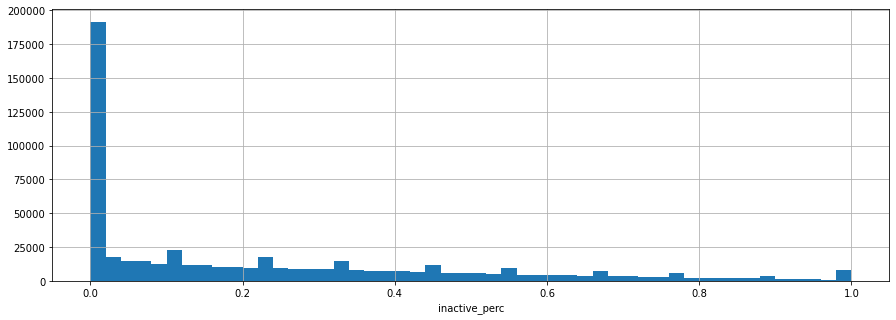

In [34]:
plt.figure(figsize=(15,5))
plt.hist(df.inactive_perc, bins=50)
plt.grid()
plt.xlabel("inactive_perc")
plt.show()

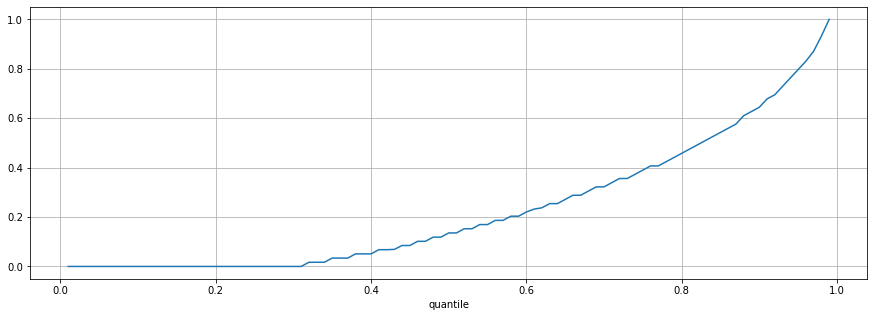

count    551472.000000
mean          0.230715
std           0.265704
min           0.000000
25%           0.000000
50%           0.135593
75%           0.389831
max           1.000000
Name: inactive_perc, dtype: float64

In [35]:
qvalues = np.arange(0.01,1,0.01)
quantiles = df.inactive_perc.quantile(qvalues)

plt.figure(figsize=(15,5))
plt.plot(qvalues, quantiles)
plt.grid()
plt.xlabel("quantile")
plt.show()

df.inactive_perc.describe()

In [36]:
# perc of skus inactive on last training date
print("Number of skus:", _data.query("date == '2021-03-31'").inactive.sum())
print("Perc of skus:", 100 * _data.query("date == '2021-03-31'").inactive.sum() / len(_data.query("date == '2021-03-31'")))

Number of skus: 99597
Perc of skus: 18.060209765863


In [37]:
# perc of skus inactive on last week of training data
print("Number of skus:", (_data.query("'2021-03-25' <= date <= '2021-03-31'").groupby("sku")["inactive"].sum() == 7).sum())
print("Perc of skus:", 100 * (_data.query("'2021-03-25' <= date <= '2021-03-31'").groupby("sku")["inactive"].sum() == 7).sum() / _data.query("'2021-03-25' <= date <= '2021-03-31'").sku.nunique())

Number of skus: 63367
Perc of skus: 11.490519917602345


In [38]:
sample = df.query("0.5 < inactive_perc < 1").sample(1)
display(sample)

,sku,inactive_perc
158220,189642,0.508475


In [39]:
_data.query("sku == @sample.sku.values[0]")

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,inactive
5477939,189642,2021-02-01,0,24.99,REA,classic,fulfillment,paid_shipping,0.000000,True
5477940,189642,2021-02-02,0,24.99,REA,classic,fulfillment,paid_shipping,0.000000,True
5477941,189642,2021-02-03,0,24.99,REA,classic,fulfillment,paid_shipping,0.000000,True
5477942,189642,2021-02-04,0,24.99,REA,classic,fulfillment,paid_shipping,0.000000,True
5477943,189642,2021-02-05,0,24.99,REA,classic,fulfillment,paid_shipping,0.000000,True
5477944,189642,2021-02-06,0,24.99,REA,classic,fulfillment,paid_shipping,0.000000,True
5477945,189642,2021-02-07,0,24.99,REA,classic,fulfillment,paid_shipping,0.000000,True
5477946,189642,2021-02-08,0,24.99,REA,classic,fulfillment,paid_shipping,0.000000,True
5477947,189642,2021-02-09,0,24.99,REA,classic,fulfillment,paid_shipping,0.000000,True
5477948,189642,2021-02-10,0,24.99,REA,classic,fulfillment,paid_shipping,0.000000,True


***
## train-m2

In [40]:
train = pd.read_parquet("../data/train-m2.parquet")
train

,sku,date,sold_quantity,current_price,currency,listing_type_classic,listing_type_premium,shipping_logistic_type_fulfillment,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_payment_free_shipping,shipping_payment_paid_shipping,minutes_active,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,q_mean,q_std,target_stock,inventory_days,item_domain_id,item_id,site_id,product_id,product_family_id
0,0,2021-02-01,0,172.789993,REA,30,0,0,30,0,30,0,1325.088257,5,5,4,4,4,4,4,0.215558,0.482631,1,inf,MLB-SNEAKERS,492155,MLB,None,MLB15832732
1,0,2021-02-02,0,172.789993,REA,30,0,0,30,0,30,0,1373.088257,4,5,5,4,4,4,4,0.215558,0.482631,1,inf,MLB-SNEAKERS,492155,MLB,None,MLB15832732
2,0,2021-02-03,0,179.990005,REA,30,0,0,30,0,30,0,1421.088257,4,4,5,5,4,4,4,0.215558,0.482631,1,inf,MLB-SNEAKERS,492155,MLB,None,MLB15832732
3,0,2021-02-04,0,179.990005,REA,30,0,0,30,0,30,0,1440.000000,4,4,4,5,5,4,4,0.215558,0.482631,1,inf,MLB-SNEAKERS,492155,MLB,None,MLB15832732
4,0,2021-02-05,0,179.990005,REA,30,0,0,30,0,30,0,1440.000000,4,4,4,4,5,5,4,0.215558,0.482631,1,inf,MLB-SNEAKERS,492155,MLB,None,MLB15832732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15524803,660914,2021-02-26,1,59.990002,REA,0,30,30,0,0,0,30,1440.000000,4,4,4,4,5,5,4,0.423169,0.759259,5,8.0,MLB-SNEAKERS,490874,MLB,None,None
15524804,660914,2021-02-27,0,59.990002,REA,0,30,30,0,0,0,30,1440.000000,4,4,4,4,4,5,5,0.423169,0.759259,5,9.0,MLB-SNEAKERS,490874,MLB,None,None
15524805,660914,2021-02-28,1,59.990002,REA,0,30,30,0,0,0,30,1440.000000,5,4,4,4,4,4,5,0.423169,0.759259,5,8.0,MLB-SNEAKERS,490874,MLB,None,None
15524806,660914,2021-03-01,0,59.990002,REA,0,30,30,0,0,0,30,1440.000000,5,5,4,4,4,4,4,0.423169,0.759259,5,9.0,MLB-SNEAKERS,490874,MLB,None,None


In [41]:
train.query("inventory_days <= 30").groupby("sku")["date"].count().quantile(np.arange(0.1, 0.51, 0.05))

0.10     9.0
0.15    12.0
0.20    16.0
0.25    19.0
0.30    22.0
0.35    24.0
0.40    27.0
0.45    29.0
0.50    30.0
Name: date, dtype: float64

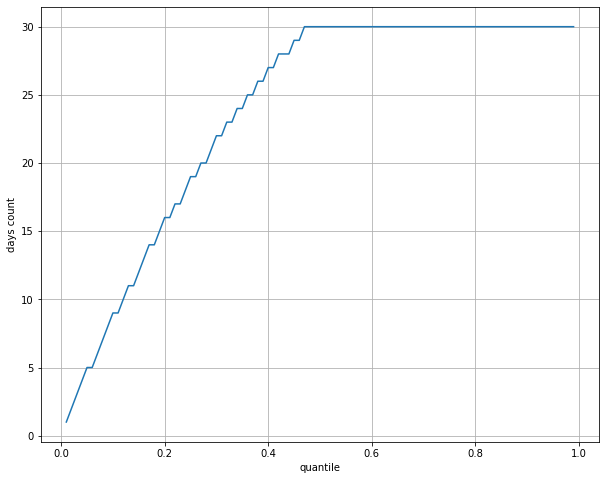

In [42]:
qx = np.arange(0.01, 1, 0.01)
qy = train.query("inventory_days <= 30").groupby("sku")["date"].count().quantile(qx)

plt.figure(figsize=(10,8))
plt.plot(qx, qy)
plt.grid()
plt.xlabel("quantile")
plt.ylabel("days count")
plt.show()

In [43]:
len(train.query("inventory_days <= 30")) / 1e6

10.51947

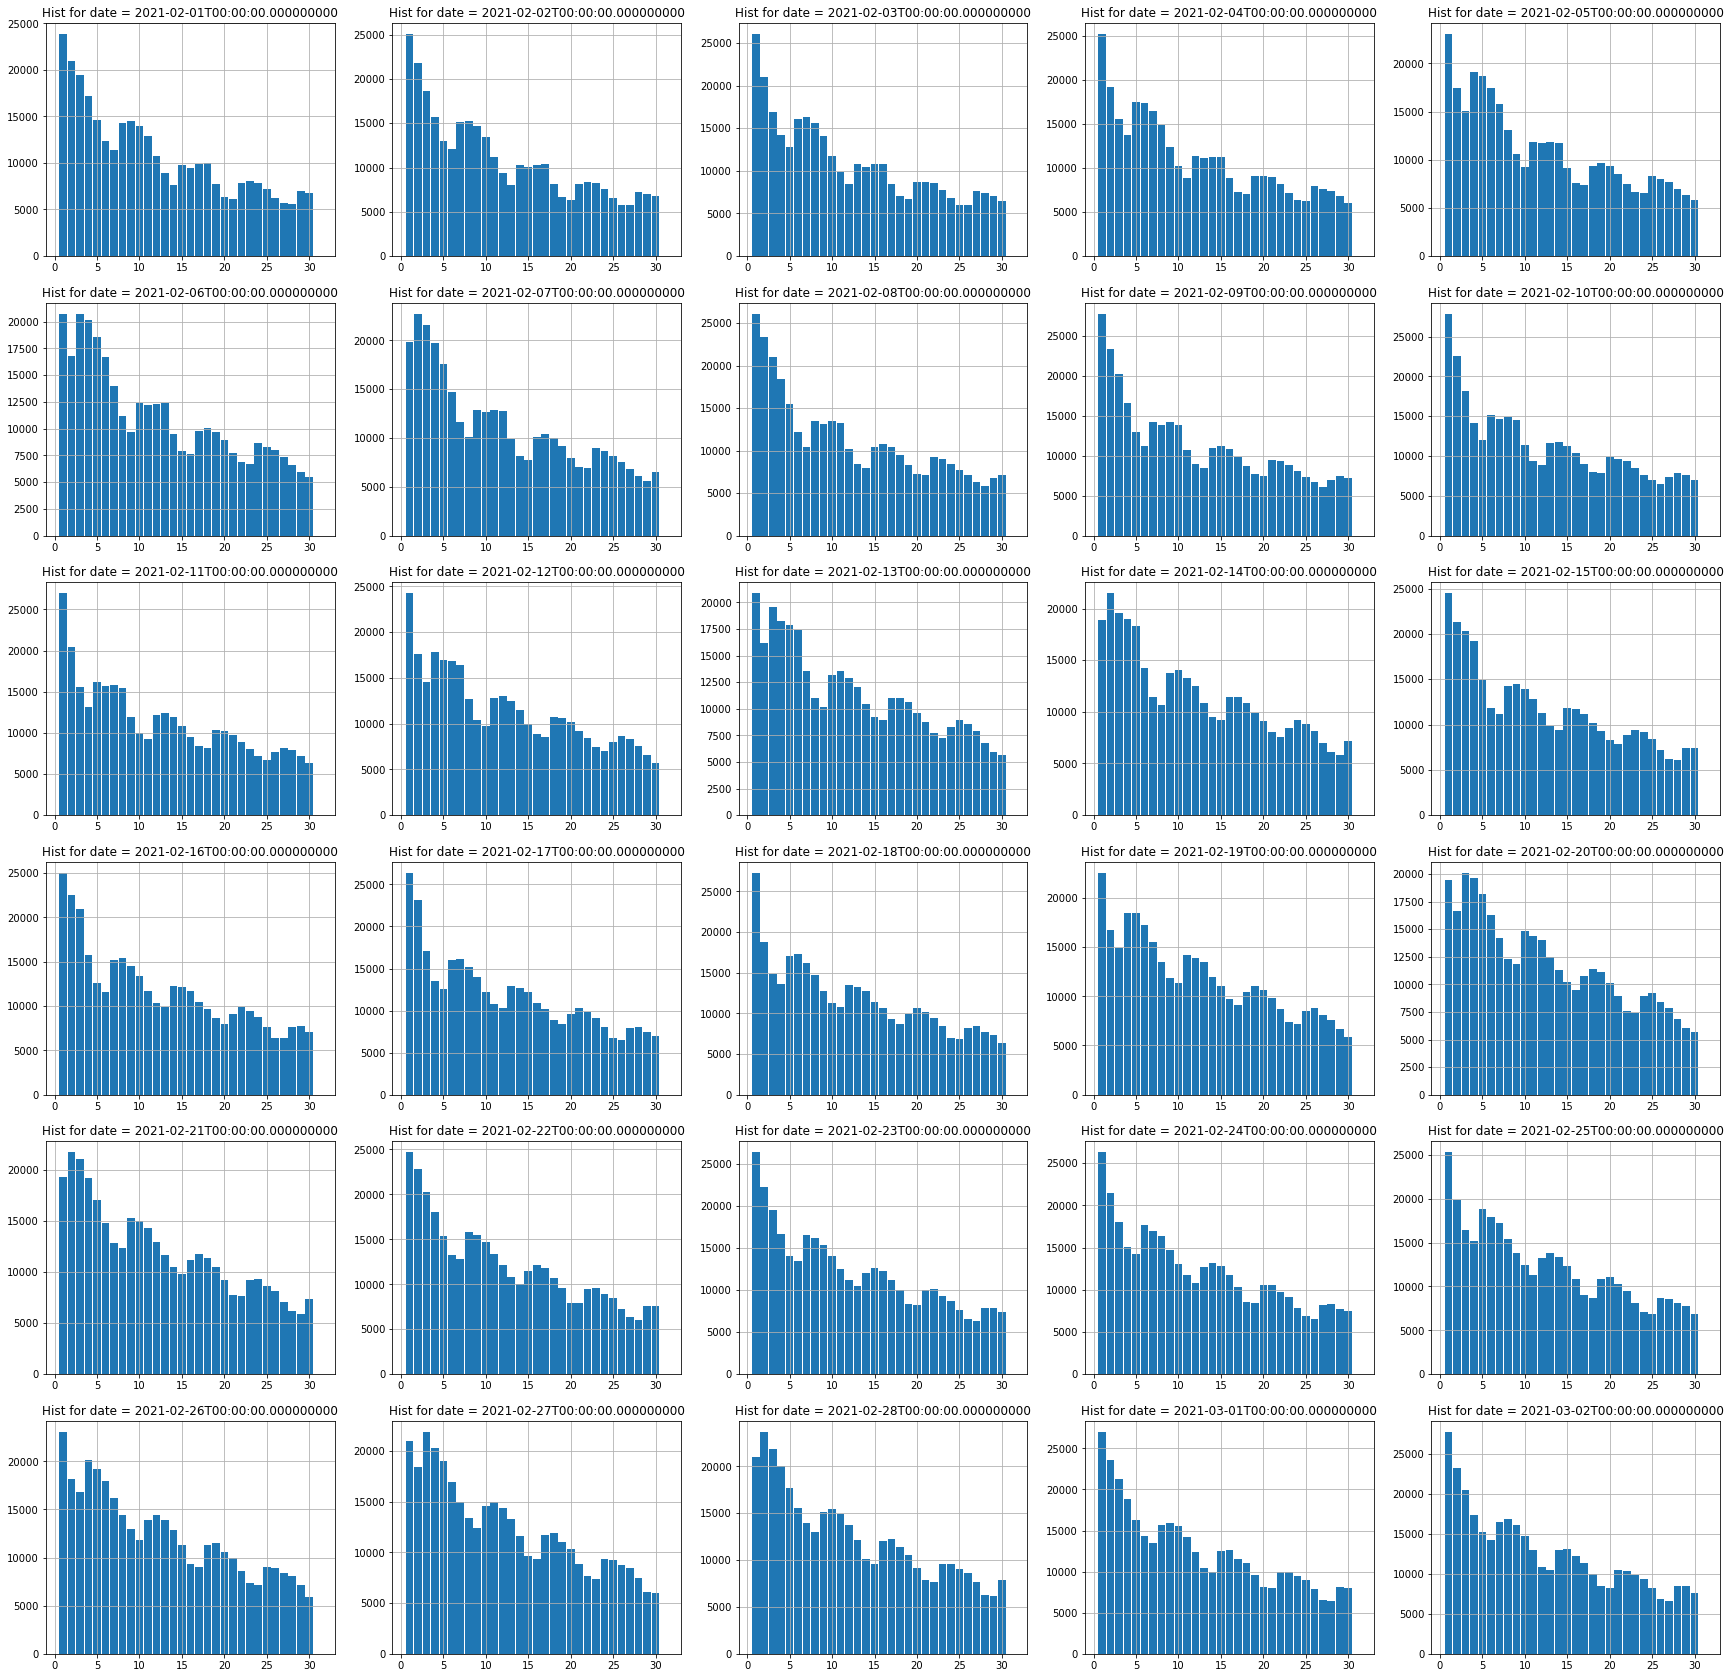

In [44]:
# without uncensored
plt.figure(figsize=(30,30))
for i,date in enumerate(train.date.unique()):
    df = train.query("date == @date").copy()
    plt.subplot(6,5,i+1)
    plt.hist(df.inventory_days.values, bins=np.arange(1,33), align="left", rwidth=0.9)
    plt.grid()
    plt.title(f"Hist for date = {date}")
plt.show()

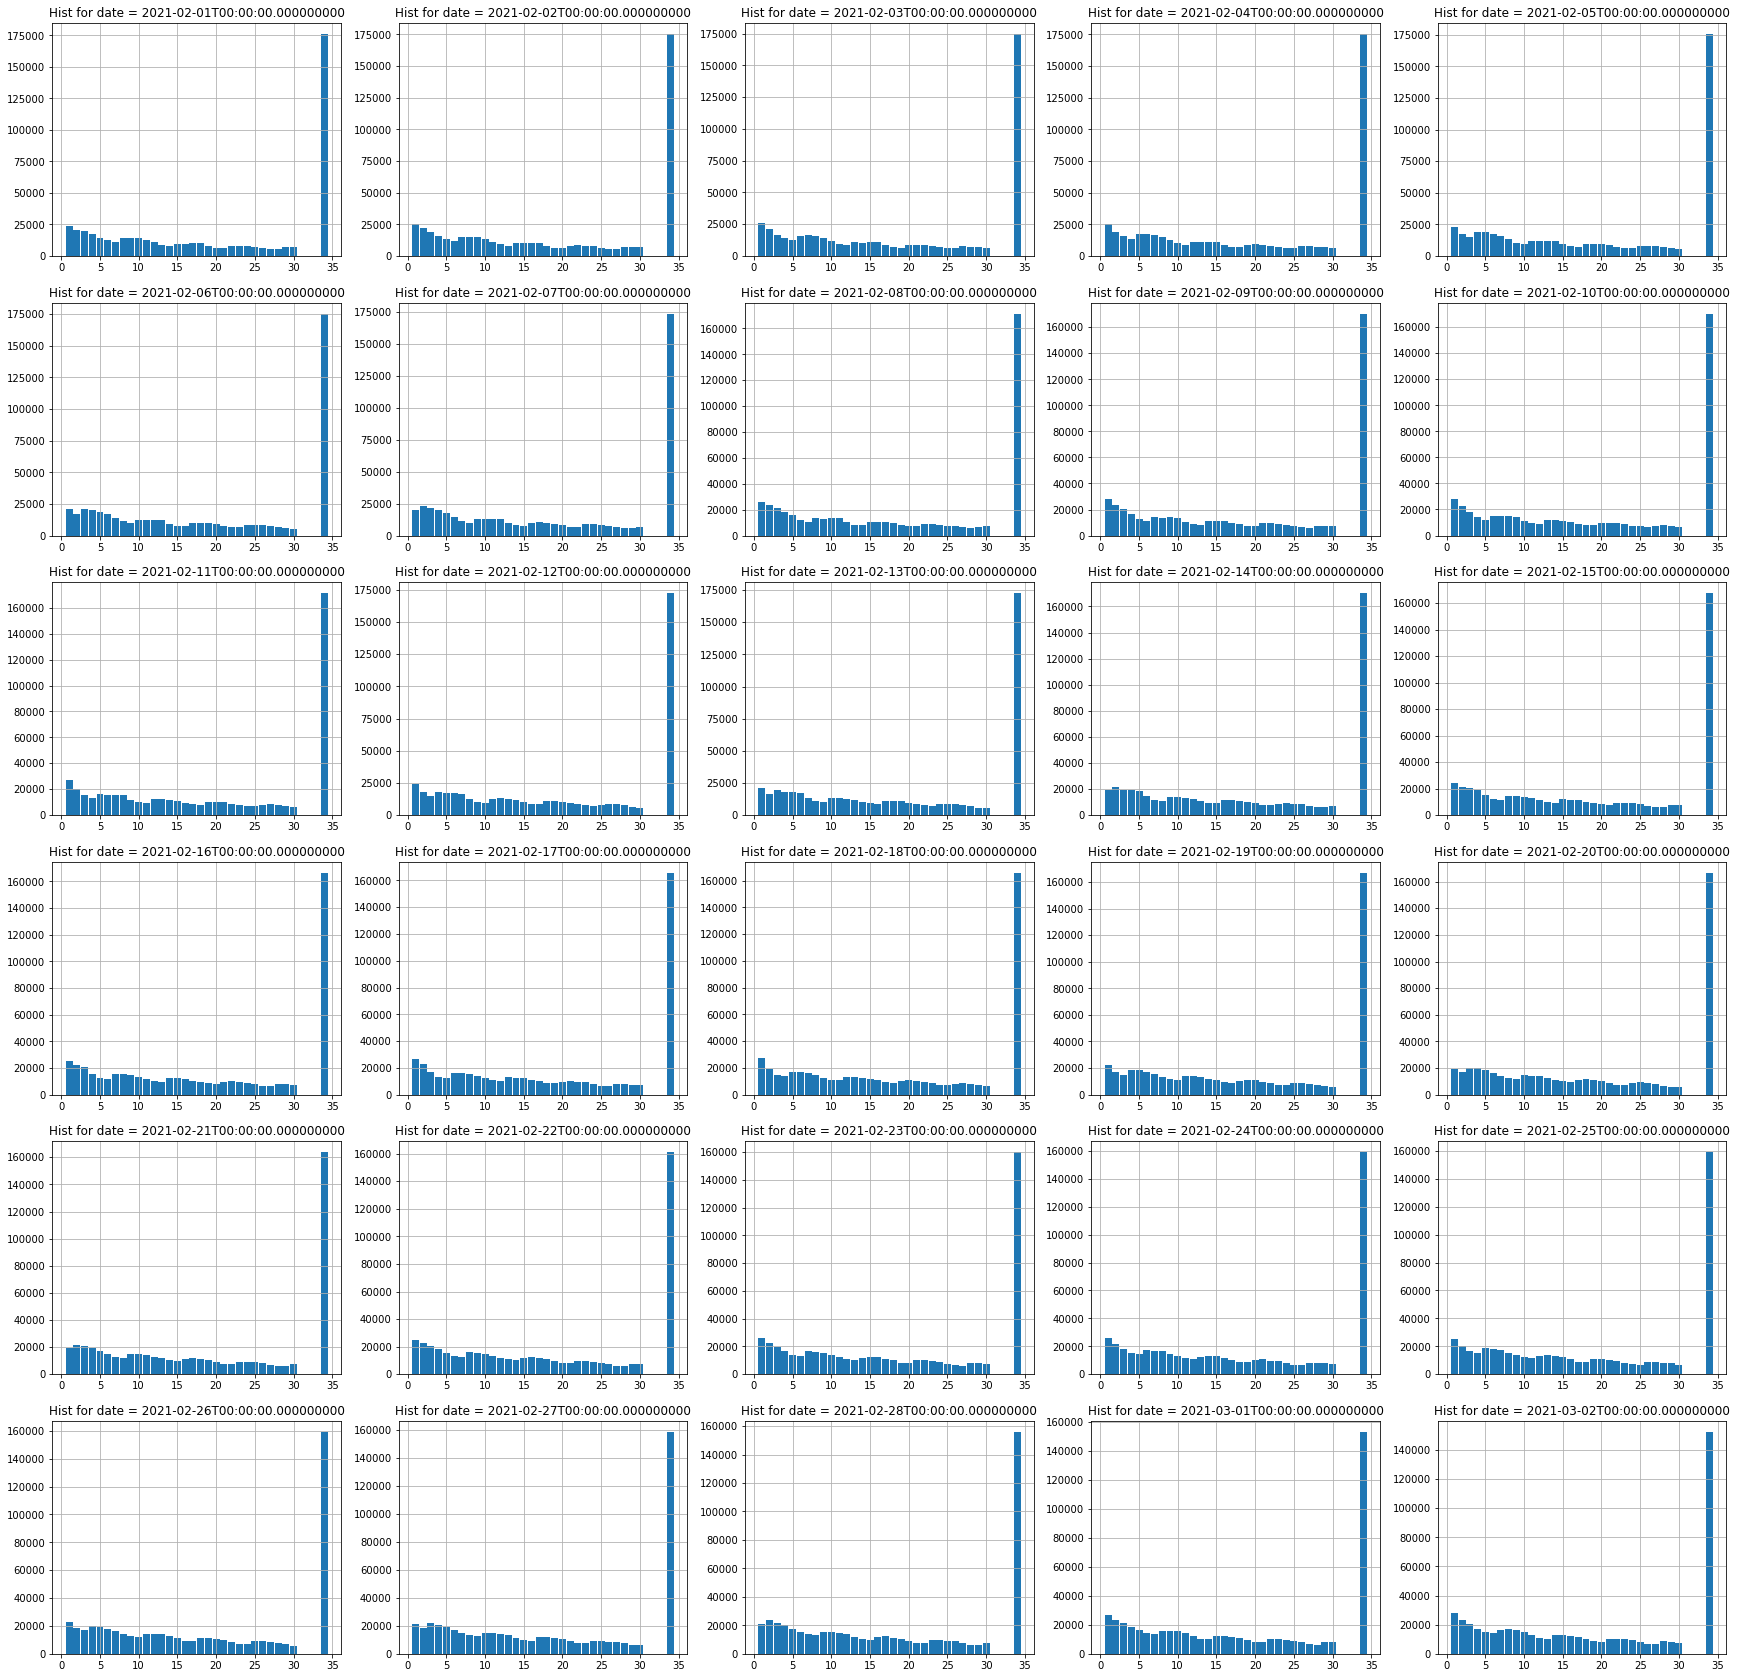

In [45]:
# with uncensored
plt.figure(figsize=(30,30))
for i,date in enumerate(train.date.unique()):
    df = train.query("date == @date").copy()
    idx = df.query("inventory_days > 30").index
    df.loc[idx,"inventory_days"] = 35
    plt.subplot(6,5,i+1)
    plt.hist(df.inventory_days.values, bins=np.arange(1,36), align="left", rwidth=0.9)
    plt.grid()
    plt.title(f"Hist for date = {date}")
plt.show()

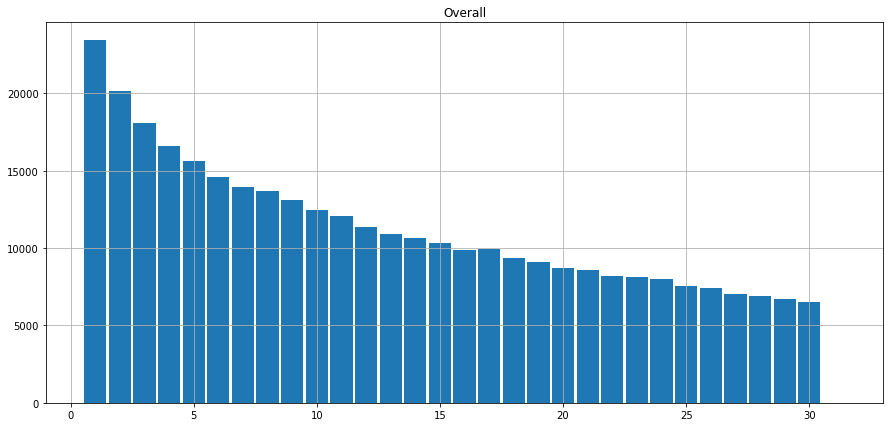

In [46]:
plt.figure(figsize=(15,7))
plt.hist(train.sample(500000).inventory_days.values, bins=np.arange(1,33), align="left", rwidth=0.9)
plt.grid()
plt.title("Overall")
plt.show()

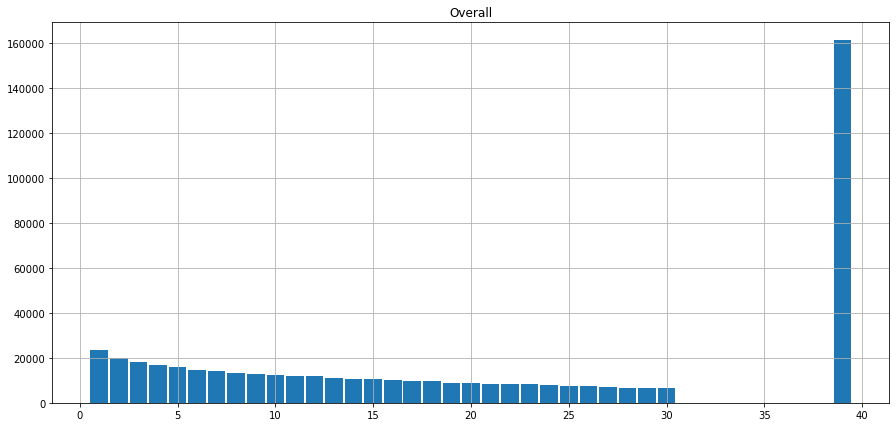

In [47]:
idx = train.query("inventory_days > 30").index
train.loc[idx,"inventory_days"] = 40

plt.figure(figsize=(15,7))
plt.hist(train.sample(500000).inventory_days.values, bins=np.arange(1,41), align="left", rwidth=0.9)
plt.grid()
plt.title("Overall")
plt.show()

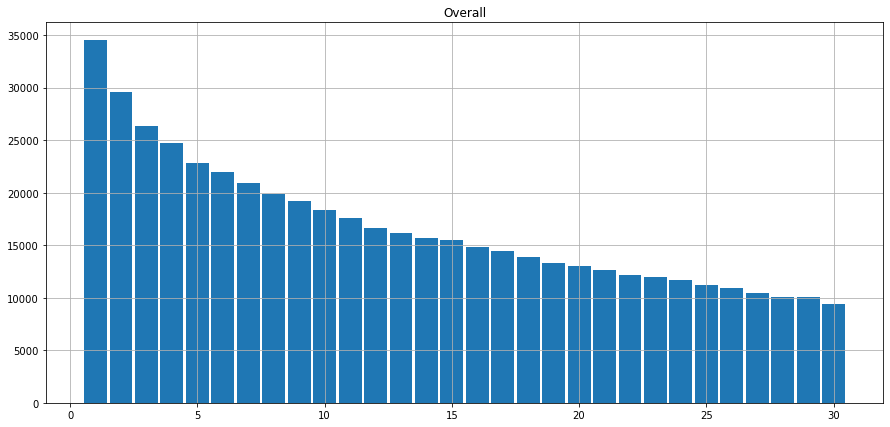

In [48]:
plt.figure(figsize=(15,7))
plt.hist(train.query("inventory_days <= 30").sample(500000).inventory_days.values, bins=np.arange(1,32), align="left", rwidth=0.9)
plt.grid()
plt.title("Overall")
plt.show()

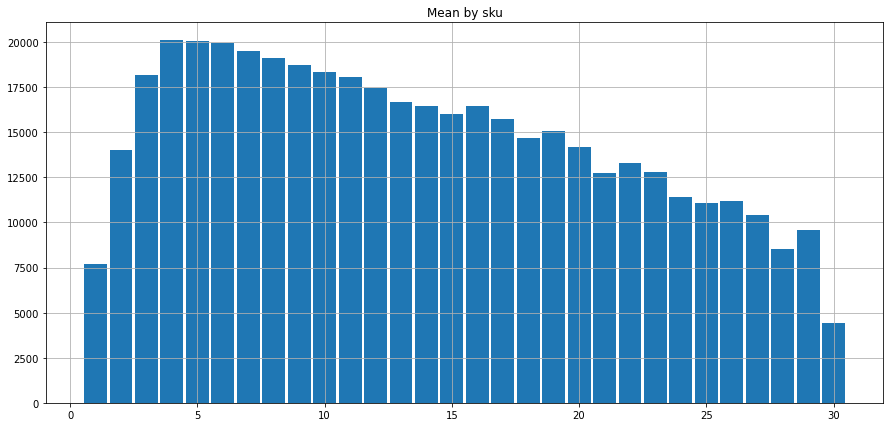

In [49]:
plt.figure(figsize=(15,7))
plt.hist(train.query("inventory_days <= 30").groupby("sku")["inventory_days"].mean(), bins=np.arange(1,32), align="left", rwidth=0.9)
plt.grid()
plt.title("Mean by sku")
plt.show()

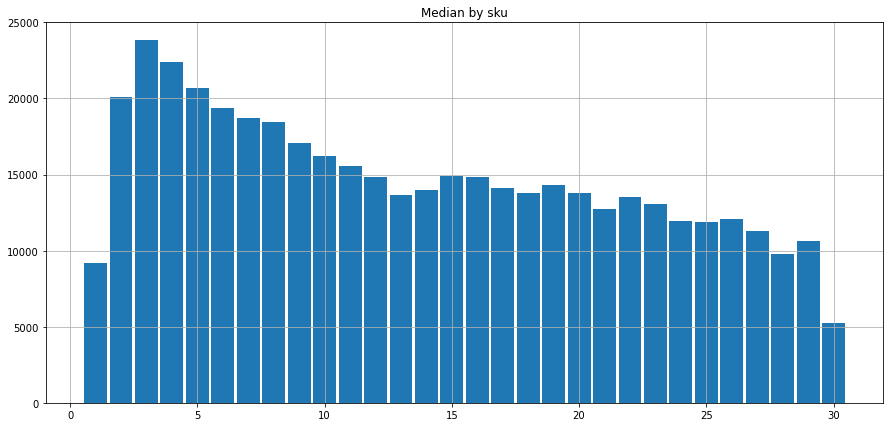

In [50]:
plt.figure(figsize=(15,7))
plt.hist(train.query("inventory_days <= 30").groupby("sku")["inventory_days"].median(), bins=np.arange(1,32), align="left", rwidth=0.9)
plt.grid()
plt.title("Median by sku")
plt.show()

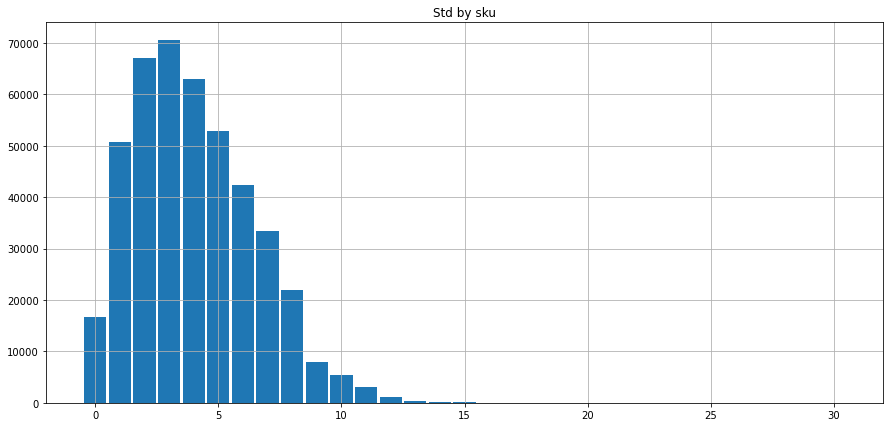

In [51]:
plt.figure(figsize=(15,7))
plt.hist(train.query("inventory_days <= 30").groupby("sku")["inventory_days"].std(), bins=np.arange(0,32), align="left", rwidth=0.9)
plt.grid()
plt.title("Std by sku")
plt.show()

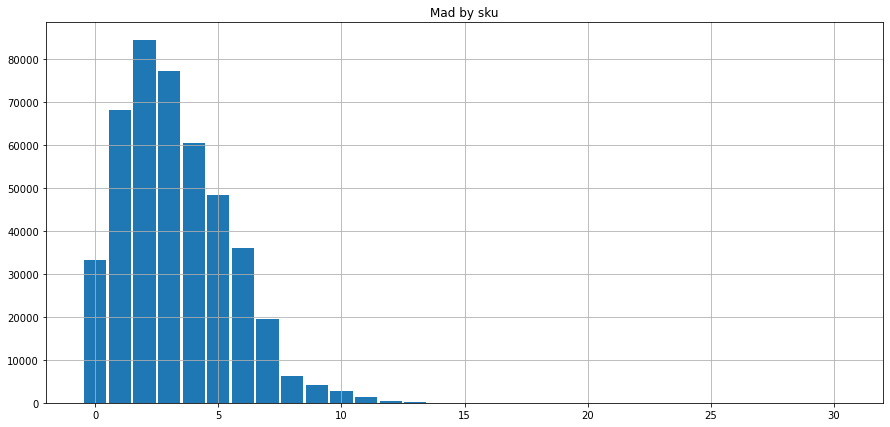

In [52]:
plt.figure(figsize=(15,7))
plt.hist(train.query("inventory_days <= 30").groupby("sku")["inventory_days"].mad(), bins=np.arange(0,32), align="left", rwidth=0.9)
plt.grid()
plt.title("Mad by sku")
plt.show()

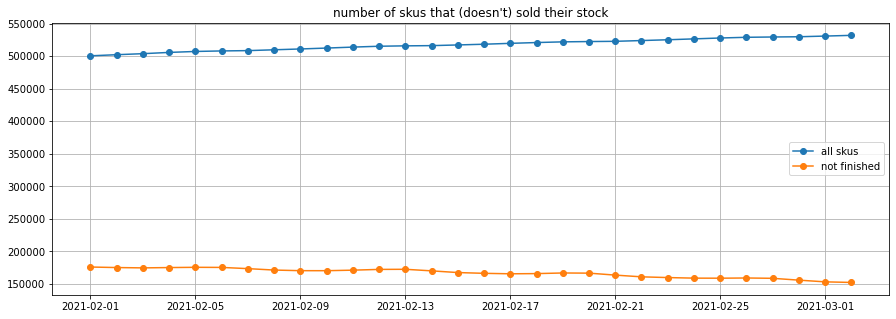

In [53]:
train["not_finished"] = train.eval("inventory_days > 30")
gb1 = train.groupby(["date"])["sku"].count()
gb2 = train.groupby(["date"])["not_finished"].sum()

plt.figure(figsize=(15,5))
plt.title("number of skus that (doesn't) sold their stock")
plt.plot_date(gb1.index, gb1.values, "o-", label="all skus")
plt.plot_date(gb2.index, gb2.values, "o-", label="not finished")
plt.grid()
plt.legend(loc="best")
plt.show()

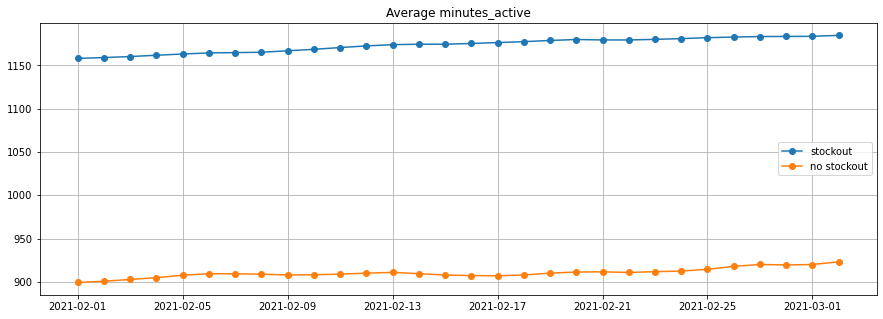

In [54]:
gb1= train.query("not not_finished").groupby("date")["minutes_active"].mean()
gb2 = train.query("not_finished").groupby("date")["minutes_active"].mean()

plt.figure(figsize=(15,5))
plt.title("Average minutes_active")
plt.plot_date(gb1.index, gb1.values, "o-", label="stockout")
plt.plot_date(gb2.index, gb2.values, "o-", label="no stockout")
plt.grid()
plt.legend(loc="best")
plt.show()

***
## SKU metadata

In [55]:
all_records = list()

with jsonlines.open('../data/items_static_metadata_full.jl') as reader:
    for obj in tqdm(reader):
        all_records.append(obj)

660916it [00:03, 174873.50it/s]


In [56]:
metadata = pd.DataFrame(all_records)
metadata

,item_domain_id,item_id,item_title,site_id,sku,product_id,product_family_id
0,MLB-SNEAKERS,492155,Tênis Masculino Olympikus Cyber Barato Promoçao,MLB,0,None,MLB15832732
1,MLB-SURFBOARD_RACKS,300279,Suporte Rack Prancha Parede C/ Regulagem Horiz...,MLB,1,None,None
2,MLM-NECKLACES,69847,5 Collares Plateados Dama Gargantilla Choker -...,MLM,2,None,None
3,MLM-RINGS,298603,Lindo Anillo De Bella Crepusculo Twilight Prom...,MLM,3,None,None
4,MLB-WEBCAMS,345949,Webcam Com Microfone Hd 720p Knup Youtube Pc V...,MLB,4,None,None
...,...,...,...,...,...,...,...
660911,MLB-CELLPHONE_PARTS,320792,2 Parafuso Pentalobe Torx iPhone 5 5c 5s 6 6s ...,MLB,660911,None,None
660912,MLM-AUTOMOTIVE_EMBLEMS,90441,Emblema Circular Wolfsburg Edition 5cm,MLM,660912,None,None
660913,MLB-SOFA_AND_FUTON_COVERS,202580,Kit Capa De Sofá Coladinha Jogo 2e3 Lugares Ma...,MLB,660913,None,None
660914,MLB-SNEAKERS,490874,Calçado Sapatênis Clássico Baltic 234 Ollie,MLB,660914,None,None


In [57]:
# % of null by column
metadata.isna().sum(axis=0)/len(metadata)

item_domain_id       0.000005
item_id              0.000000
item_title           0.000000
site_id              0.000000
sku                  0.000000
product_id           0.955111
product_family_id    0.874138
dtype: float64

In [58]:
# number of categories by column
metadata.nunique()

item_domain_id         8408
item_id              517896
item_title           478175
site_id                   3
sku                  660916
product_id            15863
product_family_id     29600
dtype: int64

***
## sku with no sales

In [59]:
nosale_skus = data.groupby("sku")["sold_quantity"].sum()[data.groupby("sku")["sold_quantity"].sum() == 0].index.values
len(nosale_skus)

25283

In [60]:
unpredictable = set(nosale_skus) & set(test.sku)
len(unpredictable)

25283

In [61]:
# 4.58% of skus have no sales
100 * len(unpredictable) / test.sku.nunique()

4.584638929991006

***
## sku without activity

In [62]:
_data = data.query("sku not in @unpredictable").reset_index(drop=True)

In [63]:
noactivity_skus = _data.groupby("sku")["minutes_active"].sum()[_data.groupby("sku")["minutes_active"].sum() == 0].index.values
len(noactivity_skus)

2

In [64]:
unpredictable = set.union(unpredictable, set(noactivity_skus) & set(test.sku))
len(unpredictable)

25285

***
## sku with few data-points

In [65]:
mask = data.query("sku not in @unpredictable").groupby("sku")["date"].count() <= 1
few_dp_skus = data.query("sku not in @unpredictable").groupby("sku")["date"].count()[mask].index.values
len(few_dp_skus)

29

In [66]:
unpredictable = set.union(unpredictable, set(few_dp_skus) & set(test.sku))
len(unpredictable)

25314

In [67]:
unpredictable = pd.DataFrame(unpredictable, columns=["sku"])
display(unpredictable)
unpredictable.to_csv("../data/unpredictable.csv", index=False)

,sku
0,131072
1,65538
2,524291
3,262149
4,393224
...,...
25309,458740
25310,327670
25311,393209
25312,393212


***
## split sku by sales volume

In [68]:
df = (
    data
    .groupby("sku")["sold_quantity"]
    .mean()
    .sort_values(ascending=False)
    .reset_index(name="mean_sales")  
)
df["pct"] = df.mean_sales.rank(ascending=False, pct=True)
df

,sku,mean_sales,pct
0,526920,2330.983051,0.000002
1,335101,1622.559322,0.000003
2,115,1155.254237,0.000005
3,578318,1130.694915,0.000006
4,535060,1012.694915,0.000008
...,...,...,...
660911,139129,0.000000,0.980874
660912,57291,0.000000,0.980874
660913,387850,0.000000,0.980874
660914,216554,0.000000,0.980874


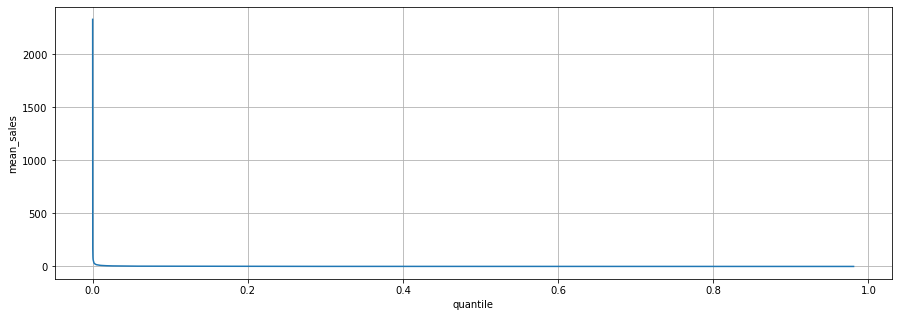

In [69]:
plt.figure(figsize=(15,5))
plt.plot(df.pct, df.mean_sales)
plt.grid()
plt.xlabel("quantile")
plt.ylabel("mean_sales")
plt.show()

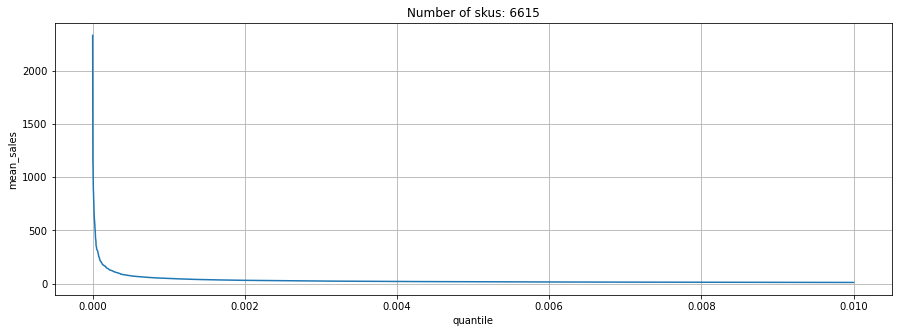

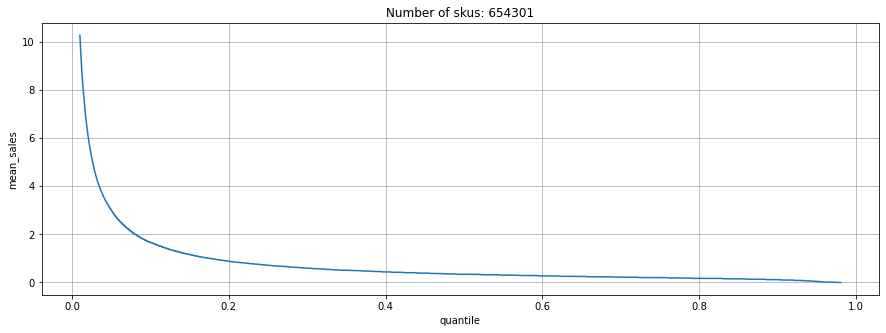

In [70]:
split_point = 0.01

plt.figure(figsize=(15,5))
plt.plot(df.query("pct <= @split_point").pct, df.query("pct <= @split_point").mean_sales)
plt.grid()
plt.xlabel("quantile")
plt.ylabel("mean_sales")
plt.title(f"Number of skus: {df.query('pct <= @split_point').sku.nunique()}")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df.query("pct > @split_point").pct, df.query("pct > @split_point").mean_sales)
plt.grid()
plt.xlabel("quantile")
plt.ylabel("mean_sales")
plt.title(f"Number of skus: {df.query('pct > @split_point').sku.nunique()}")
plt.show()

***
## scaling factors for RMSSE

In [71]:
data.sort_values(["sku","date"], inplace=True, ignore_index=True)
data

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,inactive
0,0,2021-02-01,0,172.79,REA,classic,cross_docking,free_shipping,0.00,True
1,0,2021-02-02,0,172.79,REA,classic,cross_docking,free_shipping,0.00,True
2,0,2021-02-03,0,179.99,REA,classic,cross_docking,free_shipping,872.65,False
3,0,2021-02-04,0,179.99,REA,classic,cross_docking,free_shipping,1440.00,False
4,0,2021-02-05,0,179.99,REA,classic,cross_docking,free_shipping,1440.00,False
...,...,...,...,...,...,...,...,...,...,...
37660274,660915,2021-03-27,0,79.99,MEX,classic,fulfillment,paid_shipping,0.00,True
37660275,660915,2021-03-28,0,79.99,MEX,classic,fulfillment,paid_shipping,0.00,True
37660276,660915,2021-03-29,0,79.99,MEX,classic,fulfillment,paid_shipping,0.00,True
37660277,660915,2021-03-30,0,99.99,MEX,classic,fulfillment,paid_shipping,0.00,True


In [72]:
scales = data.groupby("sku").apply(lambda df: np.sqrt(np.nanmean(df.sold_quantity.diff(1)**2)))
scales = scales.reset_index(name="scale")
scales["scale"] = scales["scale"].fillna(0)
scales

<ipython-input-72-25f65c262494>:1: RuntimeWarning: Mean of empty slice
  scales = data.groupby("sku").apply(lambda df: np.sqrt(np.nanmean(df.sold_quantity.diff(1)**2)))


,sku,scale
0,0,0.669534
1,1,1.025536
2,2,0.301511
3,3,0.508548
4,4,2.463527
...,...,...
660911,660911,0.830455
660912,660912,1.033908
660913,660913,0.587220
660914,660914,1.203443


In [73]:
avgs = data.groupby("sku")["sold_quantity"].mean()
avgs = avgs.reset_index(name="avg")
avgs

,sku,avg
0,0,0.186441
1,1,0.372881
2,2,0.043478
3,3,0.135593
4,4,0.661017
...,...,...
660911,660911,0.322034
660912,660912,0.237288
660913,660913,0.169492
660914,660914,0.389831


In [74]:
scales = pd.merge(scales, avgs, how="inner", on="sku")
scales

,sku,scale,avg
0,0,0.669534,0.186441
1,1,1.025536,0.372881
2,2,0.301511,0.043478
3,3,0.508548,0.135593
4,4,2.463527,0.661017
...,...,...,...
660911,660911,0.830455,0.322034
660912,660912,1.033908,0.237288
660913,660913,0.587220,0.169492
660914,660914,1.203443,0.389831


In [75]:
corr_factor = scales.eval("scale / avg").median()
corr_factor

2.7332977781658356

In [76]:
idx = scales.query("scale == 0").index
scales.loc[idx, "scale"] = scales.loc[idx, "avg"] * corr_factor
scales.query("scale == 0")

,sku,scale,avg
21,21,0.0,0.0
22,22,0.0,0.0
39,39,0.0,0.0
134,134,0.0,0.0
138,138,0.0,0.0
...,...,...,...
660762,660762,0.0,0.0
660807,660807,0.0,0.0
660814,660814,0.0,0.0
660826,660826,0.0,0.0


In [77]:
(scales
 .drop("avg", axis=1)
 .to_csv("../data/scales.csv", index=False)
)

***